In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib widget

# DFT and Poisson

#### Make historgram of expectation 10 pe per ns for 1024 ns, 4096 times with no correlations

In [2]:
ntotal = npr.poisson(10*1024*4096)
times = npr.random(ntotal)
samples, bins = np.histogram(1024*4096*times,1024*4096,(0,1024*4096))
samples = samples.reshape(-1,1024)

In [3]:
from scipy.fft import fft, ifft

In [4]:
n = samples
N = fft(n,axis=-1)

#### Plot the first sample and its FFT (specifically the complex magnitude squared of the components below the nyquist frequency)

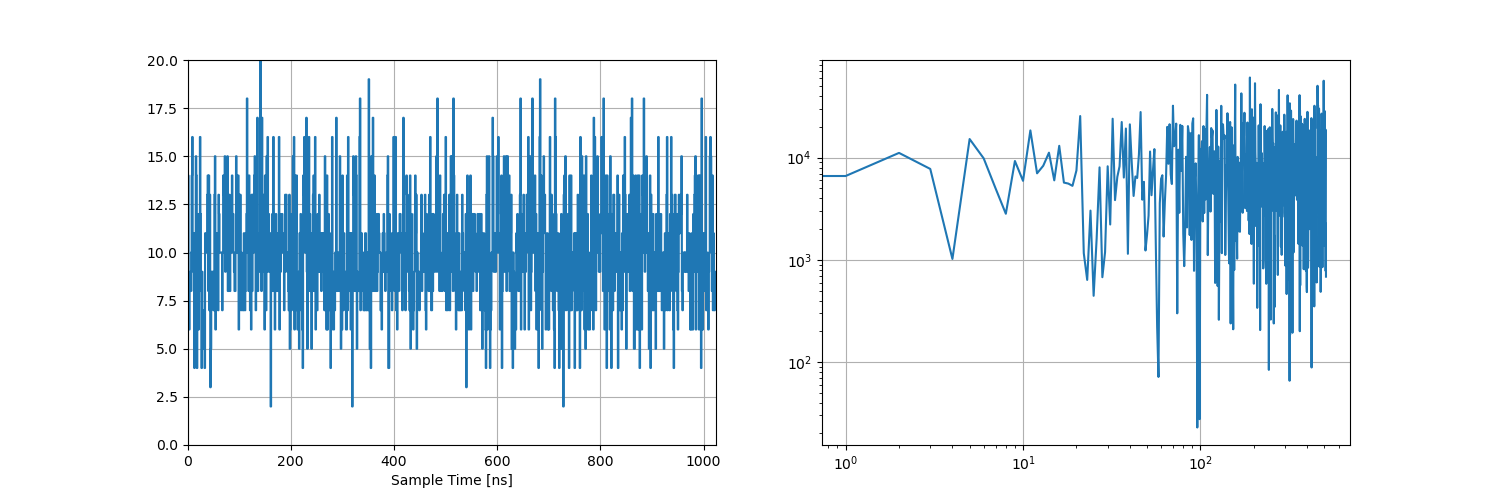

In [5]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
ax.plot(n[0],ds='steps')
ax.set_xlim(0,1024)
ax.set_ylim(0,20)
ax.set_xlabel('Sample Time [ns]')
ax.grid()

ax = plt.subplot(1,2,2)
ax.plot((N[0,1:512]*N[0,1:512].conj()).real)
ax.loglog()
ax.grid()

#### Make means across the 4096 samples

In [6]:
nn = n.mean(axis=0)
NN = np.abs(N*N.conj()).mean(axis=0)

#### Plot the means

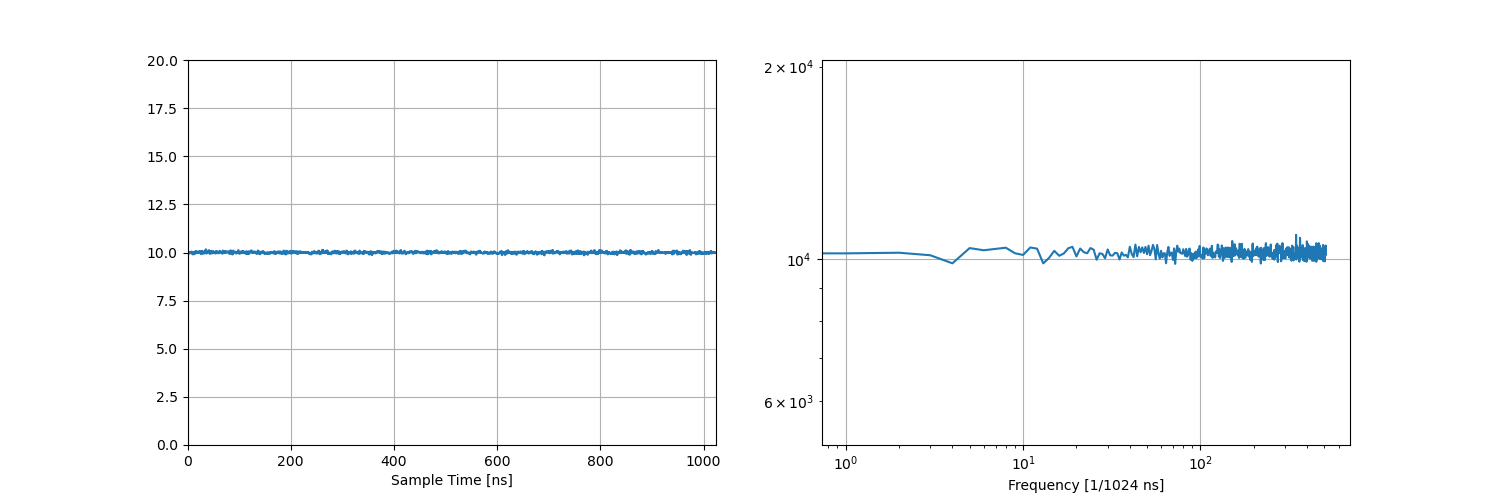

In [7]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
ax.plot(nn,ds='steps')
ax.set_xlim(0,1024)
ax.set_ylim(0,20)
ax.set_xlabel('Sample Time [ns]')
ax.grid()

ax = plt.subplot(1,2,2)
ax.plot(NN[1:512])
ax.set_yticks([5120,10240,20480])
ax.set_ylim([5120,20480])
ax.loglog()
ax.set_xlabel('Frequency [1/1024 ns]')
ax.grid()

The FFT power at each frequency seems to be $10\times1024$. That is the variance in the whole sample (also the *mean* in the whole sample)

In [8]:
print("The variance first few samples is:")
print("{:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f}".format(*n[:6].var(axis=1)))

The variance first few samples is:
 9.43  9.28 10.35  9.87 10.18  9.58


In [9]:
N2 = np.abs(N*N.conj())

In [10]:
print("The average DFT (no DC) of the first few samples is:")
print("{:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f}".format(*N2[:6,1:].mean(axis=1)/1024))

The average DFT (no DC) of the first few samples is:
 9.44  9.29 10.36  9.87 10.19  9.59


So it seems that if one takes the magnitude-squared of the DFT, scales that down by the number of bins, and averages over the non-DC frequencies, one recovers the variance to much better than the particular sample variance.

#### Check the simple sum for the DC FFT and the alternating sum for the Nyquist FFT

First the DC component

In [11]:
N[:,0] == n.sum(axis=-1)

array([ True,  True,  True, ...,  True,  True,  True])

Then the Nyquist frequency

In [12]:
N[:,1024//2] == n[:,0::2].sum(axis=1) - n[:,1::2].sum(axis=1)

array([ True,  True,  True, ...,  True,  True,  True])

Then half the Nyquist frequency, which reuires complex numbers

In [13]:
N[:,1024//4] == n[:,0::4].sum(axis=1) - 1j*n[:,1::4].sum(axis=1) - n[:,2::4].sum(axis=1) + 1j*n[:,3::4].sum(axis=1)

array([ True,  True,  True, ...,  True,  True,  True])

### Put in correlations

In [14]:
from tunka import tunka
from tunka_fit import TunkaPMTPulse

Use Tunka waveform with 10 ns risetime and 20 ns fall time. Make sure it's normalized to not move FFTs later

In [15]:
tst = np.arange(-10,20,1).astype('float')
t0 = 0.
pk = 1.
rt = 3.
ft = 6.
bl = 0.
tpars = (t0,pk,rt,ft,bl)
tunka_ts = tunka(tst,*tpars)
tunka_ts /= tunka_ts.sum()

tp = TunkaPMTPulse(*tpars)

In [16]:
from scipy.stats import norm
norm_ts = norm.pdf(tst,scale=10)

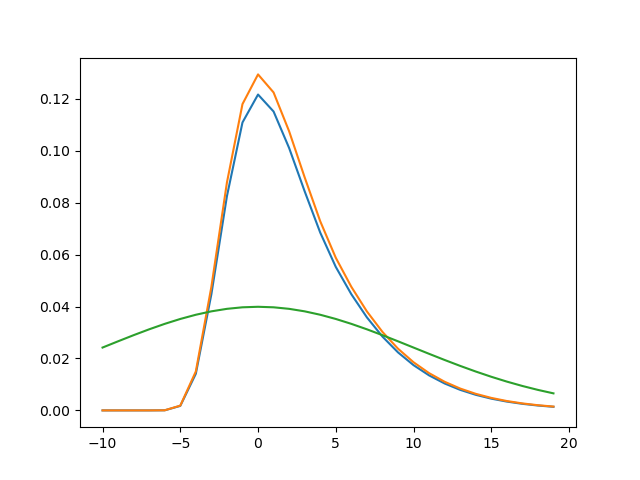

In [17]:
plt.figure()
plt.plot(tst,tunka_ts);
plt.plot(tst,tp.tunka_pdf(tst))
plt.plot(tst, norm_ts)

In [18]:
# tunka_ts = norm_ts

In [19]:
from scipy.signal import fftconvolve

#### Do full convolution, then slice out 1024 centrally (-10 and +20) because of the time limits on Tunka

In [20]:
n_cor_full = fftconvolve(n,tunka_ts[np.newaxis,:],'full')

In [21]:
n_cor = n_cor_full[:,10:-20]
# n_cor = n_cor_full
n_cor.shape

(4096, 1023)

In [22]:
N_cor = fft(n_cor)

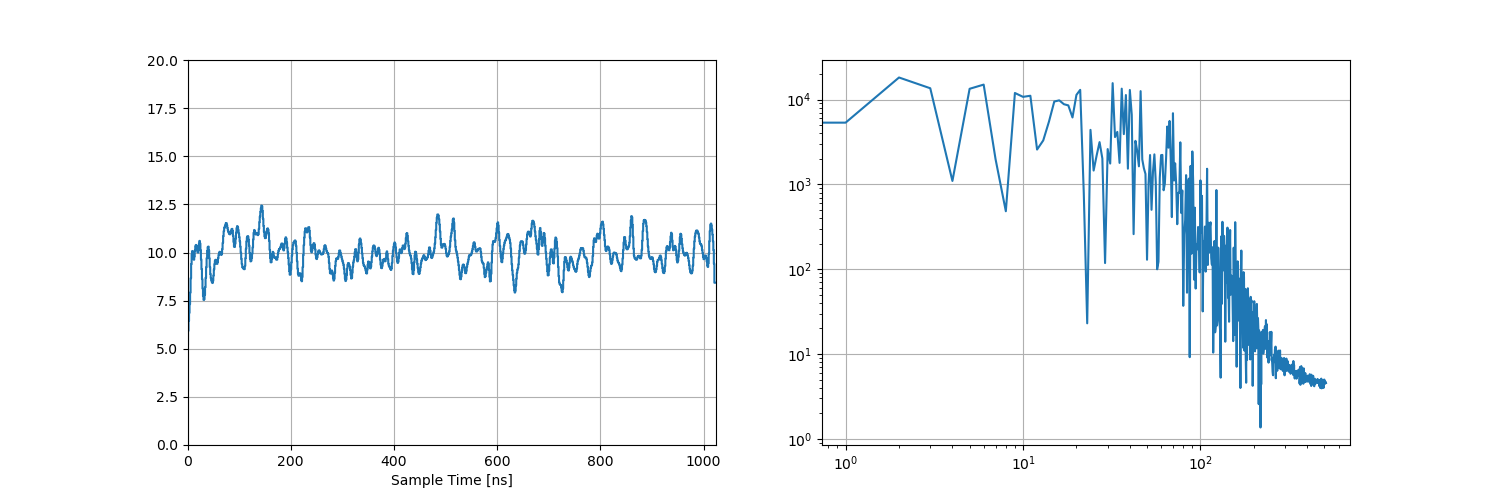

In [23]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
ax.plot(n_cor[0],ds='steps')
ax.set_xlim(0,1024)
ax.set_ylim(0,20)
ax.set_xlabel('Sample Time [ns]')
ax.grid()

ax = plt.subplot(1,2,2)
ax.plot(np.abs(N_cor[0,1:512]*N_cor[0,1:512].conj()))
ax.loglog()
ax.grid()

The correlation make the timeseries noticable *less noisy* (particularly, *smaller variance*)

In [24]:
nn_cor = n_cor.mean(axis=0)
NN_cor = np.abs(N_cor*N_cor.conj()).mean(axis=0)

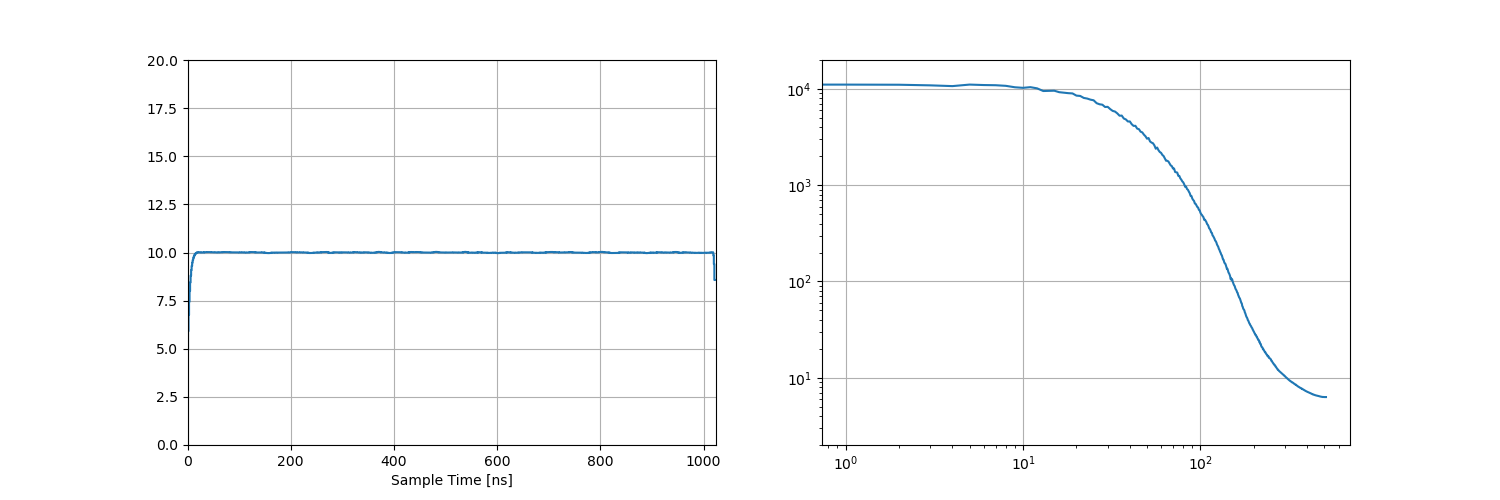

In [25]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
ax.plot(nn_cor,ds='steps')
ax.set_xlim(0,1024)
ax.set_ylim(0,20)
ax.set_xlabel('Sample Time [ns]')
ax.grid()

ax = plt.subplot(1,2,2)
ax.plot(NN_cor[1:512])
# ax.set_yticks([5120,10240,20480])
ax.set_ylim([2,2.e4])
ax.loglog()
ax.grid()

In [26]:
print("The variance first few samples is:")
print("{:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f}".format(*n_cor[:6].var(axis=1)))

The variance first few samples is:
 0.72  0.80  0.89  0.84  0.90  0.88


In [27]:
N2_cor = np.abs(N_cor*N_cor.conj())

In [28]:
print("The average DFT (no DC) of the first few samples is:")
print("{:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f}".format(*N2_cor[:6,1:].mean(axis=1)/1024))

The average DFT (no DC) of the first few samples is:
 0.72  0.80  0.89  0.84  0.90  0.88


In [29]:
print("{:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f}".format(*N2_cor[:6,1:].mean(axis=1)))

742.31 823.99 910.42 860.86 920.37 897.76


Note that the average DFT hits the observed variance, but the high-frequency variance is *much* smaller than that.

#### Try with a gain of 2 (making the area of the tunka pulse 2)

In [30]:
n_2cor_full = fftconvolve(n,2*tunka_ts[np.newaxis,:],'full')

n_2cor = n_2cor_full[:,10:-20]
N_2cor = fft(n_2cor)
nn_2cor = n_2cor.mean(axis=0)
NN_2cor = np.abs(N_2cor*N_2cor.conj()).mean(axis=0)

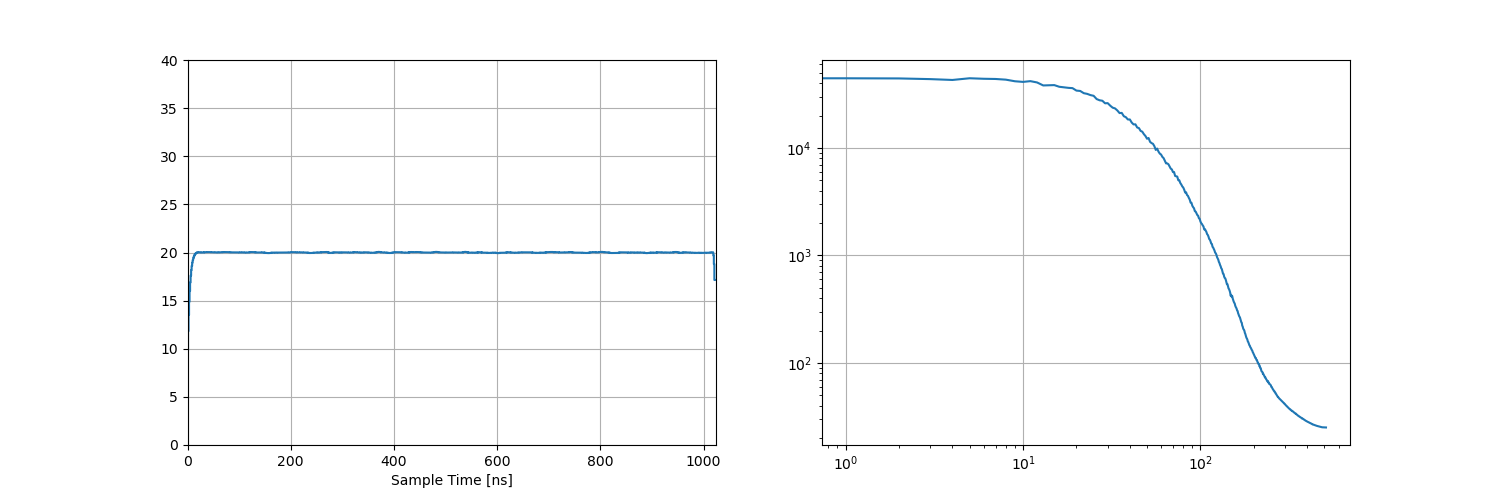

In [31]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
ax.plot(nn_2cor,ds='steps')
ax.set_xlim(0,1024)
ax.set_ylim(0,40)
ax.set_xlabel('Sample Time [ns]')
ax.grid()

ax = plt.subplot(1,2,2)
ax.plot(NN_2cor[1:512])
# ax.set_yticks([5120,10240,20480])
# ax.set_ylim([2,2.e4])
ax.loglog()
ax.grid()

So the power level goes up by 4, which is sensible cause it is squared.

#### Calculating the NSBG

So we should by able to recover the NSBG by taking the average LF power spectrum, normalizing it by the number of time-sequence bins and dividing out the gain-squared.

In [32]:
nsbg = np.abs(N_2cor*N_2cor.conj()/1024).mean(axis=0)/4

In [33]:
print(nsbg[1:5])

[11.02490641 10.84127411 10.80726554 10.64958708]


In [34]:
print(nsbg[-1:-5:-1])

[11.02490641 10.84127411 10.80726554 10.64958708]


So, yes, the LF parts of the DFT give the NSBG that we put in, *but*, they do seem to be systematically high by about 5%.